In [1]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
import matplotlib.ticker as ticker
from metpy.plots import ctables
from pyPIPS import disdrometer_module as dis
from pyPIPS import timemodule as tm
from pyPIPS.utils import mtokm, getTimeWindow
from pyPIPS import plotmodule as pm
from pyPIPS import fmcw
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from skimage.restoration import unwrap_phase
import skimage.feature as SF
import numpy.ma as ma
from scipy import ndimage, interpolate
%load_ext autoreload
%autoreload 2


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
fmcw_data_dir = '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/'
starttimestring = '201604292100'
endtimestring = '201604300300'

filepaths = fmcw.get_fmcw_filepaths(fmcw_data_dir, starttimestring, endtimestring)
print(filepaths)

['/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T220010.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T230008.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T210001.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T010009.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T030000.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T020010.nc', '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T000151.nc']


In [3]:
datasets = []
for file in filepaths:
    print("Reading " + file)
    datasets.append(fmcw.read_fmcw_xarray(file))

Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T220010.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T230008.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0429/S20160429T210001.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T010009.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T030000.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T020010.nc
Reading /Users/dawson29/pyPIPS_work/VORTEXSE/2016/fmcw_data/0430/S20160430T000151.nc


In [4]:
# Why does the following remove the global attributes? TODO: try "keep_attrs = True" next time.
fmcw_merged_dataset = xr.combine_by_coords(datasets)
# Restore the global attributes
fmcw_merged_dataset.attrs = datasets[0].attrs

In [5]:
Zef_list = []
for dataset in datasets:
    Zef_list.append(dataset['Zef'])
Zef_merged = xr.concat(Zef_list, dim='time')
Zef_merged = Zef_merged.sortby('time')

In [7]:
# Dealias
fmcw.dealias(fmcw_merged_dataset)

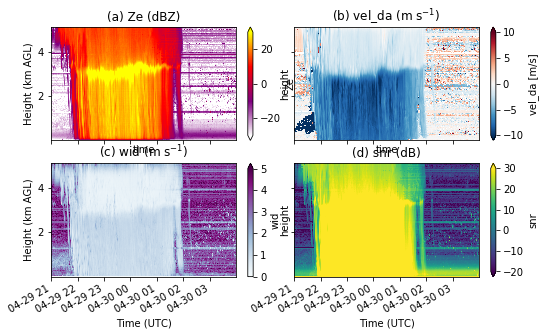

In [8]:
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (20,10)
fmcw.plot_fmcw_4panel_xarray(fmcw_merged_dataset)

In [9]:
dis_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2016/PIPS/processed/PIPS1A_special/'
dis_filename = 'PIPS_1A_IOP_4A_4D_D1.txt'
dis_filepath = os.path.join(dis_dir, dis_filename)
PIPS_dict = dis.readPIPS(dis_filepath, requested_interval=60., 
                         starttime=starttimestring, stoptime=endtimestring, rainonlyqc=True)

270416 225136
2016-04-27 22:51:33
2016 4 27 22 51 33
2016-04-27 22:51:36 2016-04-27 22:51:33
GPS Offset 0:00:03
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Severe Wind contamination, masking entire PSD!
Requested DSD interval: 60.0. Actual DSD interval: 60.0


In [ ]:
ND = PIPS_dict['ND'].T
logND = ma.log10(ND)
DSD_index = PIPS_dict['DSD_index']
DSD_interval = PIPS_dict['DSD_interval']
DSD_interval_td = timedelta(seconds=DSD_interval)
DSD_halfinterval_td = timedelta(seconds=DSD_interval / 2.)

# Determine start and end times/indices for analysis
PSDtimestamps = PIPS_dict['PSDtimestamps']
PSDtimestampsnums = md.date2num(PSDtimestamps)

#     plotstarttime = starttime
#     plotstoptime = stoptime

pstartindex, pstopindex = getTimeWindow(starttimestring, endtimestring, PSDtimestampsnums)

pstarttime = PSDtimestampsnums[pstartindex]
pstoptime = PSDtimestampsnums[pstopindex]

plotstarttime = pstarttime
plotstoptime = pstoptime

PSDtimestamps_edge = [x - DSD_interval_td for x in PSDtimestamps]
# Add an extra 10 sec for the last time bin boundary
PSDtimestamps_edge.append(PSDtimestamps_edge[-1] + DSD_interval_td)
PSDtimestamps_avg = [x - DSD_halfinterval_td for x in PSDtimestamps]
PSDstarttimes = md.date2num(PSDtimestamps_edge[pstartindex:pstopindex + 1])
PSDmidtimes = md.date2num(PSDtimestamps_avg[pstartindex:pstopindex + 1])

scattfile = '/Users/dawson29/Projects/pyPIPS/tmatrix/FMCW/SCTT_RAIN_fw100.dat'
# Observed DSD: TODO, need to make ND, ND_expDSD, and ND_gamDSD have consistent units!
dualpol_dis = dis.calpolrain(15.0, scattfile, ND, dis.bin_width)
dis_ref = dualpol_dis.get('dBZ', np.empty((0)))
logND_plot = logND[:, pstartindex:pstopindex + 1]
disvars = {'min_diameter': dis.min_diameter, 'PSDstarttimes': PSDstarttimes,
           'PSDmidtimes': PSDmidtimes, 'logND': logND_plot}
# disvars['dBZ'] = dis_ref[pstartindex:pstopindex + 1]

# Quick and dirty rayleigh scattering approximation

M6 = []
print(ND.shape)
for t in range(ND.shape[-1]):
    temp_M6 = ((dis.avg_diameter[:] / 1000.)**6.) * (1000. * ND[:, t]) * dis.bin_width[:] / 1000.
    temp_M6 = np.nansum(temp_M6)
    M6.append(temp_M6)

M6 = np.array(M6, dtype=np.float64)
refl_disd = 10.0 * np.log10(1e18 * M6)
disvars['dBZ'] = refl_disd[pstartindex:pstopindex + 1]

# fig, ax = plt.subplots()

# ax.plot(PSDmidtimes, disvars['dBZ'])

radz = 500. # (m) Height of FMCW gate to plot
radzindex = int(radz / 5.)

plotx_rad = fmcw_merged_dataset['time'].values
plotx_vel = fmcw_merged_dataset['vels'].values
ploty_height = fmcw_merged_dataset['height'].values
# dBZ_D_plt = fmcw_merged_dataset['Ze'].values[:, radzindex]

# print(Zef_merged.sel(height=500.))
# print(Zef_merged.sum(dim='vels').sel(height=500.) / 256.)

Zef_merged = Zef_merged.where(Zef_merged != -99.)
dBZ_D_plt = Zef_merged.sum(dim='vels').values[:, radzindex]

fig, ax = plt.subplots()

# Convert to linear units.
Ze_lin = 10.**(Zef_merged/10.)

# Ok, in order to get a match with the PIPS reflectivity, I needed to add a factor of 2 * Vmax below. It really
# should be 2 * Vmax / 256, if the Z here is actually Z. But it looks like Z as stored in the file is actually
# Z/(2. * Vmax) (in linear units) for some reason. 
# EDIT: 07/19/19. According to Steve, this is probably just a coincidence. True source of error unknown. Need to
# calibrate against disdrometer/KHTX

Ze_500 = Ze_lin.sum(dim='vels').sel(height=500.) * 2. * fmcw_merged_dataset.Vmax
Ze_500 = 10.*np.log10(Ze_500)

Ze_500.T.plot()

# Below is equivalent to multiplying by 2 * Vmax, since we are now in log units.
Ze_500_2 = fmcw_merged_dataset['Ze'].sel(height=500.) + 10.**(2.*fmcw_merged_dataset.Vmax/10.)

Ze_500_2.T.plot()
# print(Zef_merged.sel(height=500.))
# fig, ax = plt.subplots()
# print(plotx_rad.shape, plotx_vel.shape)
# plot = ax.contourf(plotx_rad, plotx_vel, Zef_merged.sel(height=500.).T)
# plt.colorbar(plot)


# for Zef in Zef_list:
#     fig, ax = plt.subplots()
#     plot = Zef.sel(height=500.).T.plot(vmin=-50., vmax=50., cmap=cm.RdBu_r)
    

# print(dBZ_D_plt.shape)

# print(fmcw_merged_dataset['height'][radzindex])
# print(fmcw_merged_dataset['Ze'][:, radzindex])

# fmcw_merged_dataset['Ze'][:, radzindex].plot()

# print(dBZ_D_plt)

radvars = {'radmidtimes': plotx_rad, 'dBZ': Ze_500}

# Prepare axis parameters
timelimits = [plotstarttime, plotstoptime]
diamlimits = [0.0, 9.0]
diamytick = 1.0

locator = md.HourLocator(interval=6)
minorlocator = md.HourLocator(interval=1)
dateformat = '%d/%H'
formatter = md.DateFormatter(dateformat)
axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

            # Ok, now we should have everything ready to go to plot the meteograms.
            # Let'er rip!
meteogram_image_dir = './'
dis_plot_name = 'PIPS1A_observed'
pm.plotDSDmeteograms(dis_plot_name, meteogram_image_dir,
                     axparams, disvars, radvars.copy(), close_fig=False)